In [62]:
'''Vanilla Hamiltonian Monte Carlo algorithm. The model is an SEIR model with 5 parameters, and the observation datasets include both the 
new infections and the new deaths. Details can be found in https://arxiv.org/pdf/1701.02434 '''

'Vanilla Hamiltonian Monte Carlo algorithm. The model is an SEIR model with 5 parameters, and the observation datasets include both the \nnew infections and the new deaths. Details can be found in https://arxiv.org/pdf/1701.02434 '

In [63]:
from diffrax import ODETerm
from jax.scipy.stats import norm,poisson
from numpy.random import default_rng
import numpy as np
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt



In [64]:
beta = jnp.log(0.4)
eta = jnp.log(1/7)
gamma = jnp.log(1/14) #0.07
q= jnp.log(0.1)
mu = jnp.log(0.01)

t_vec = jnp.linspace(0,100,100)

def SEIR(t,y,args):
  beta,eta,gamma,q,mu = args

  beta = jnp.exp(beta)
  eta = jnp.exp(eta)
  gamma = jnp.exp(gamma)
  q = jnp.exp(q)
  mu = jnp.exp(mu)

  S,E,I,R = y
  N = S+E+I+R

  dS = - beta * ((E + q * I)/N) * S
  dE = beta * ((E + q * I)/N) * S - eta*E - gamma * E
  dI = eta * E - gamma * I - mu * I
  dR = gamma * E + gamma * I


  return jnp.array([dS,dE,dI,dR])

In [65]:
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(SEIR),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=t_vec)
        )
  return solution.ys

rng_key = jax.random.PRNGKey(0)

y_true = model(t_vec,jnp.array([1000,1.,1.,0]),(beta,eta,gamma,q,mu))

rng = default_rng(1)

data_newI = rng.poisson(jnp.exp(eta) * y_true[:,1] + 0.005)

data_newD = rng.poisson(jnp.exp(mu) * y_true[:,2] + 0.005)


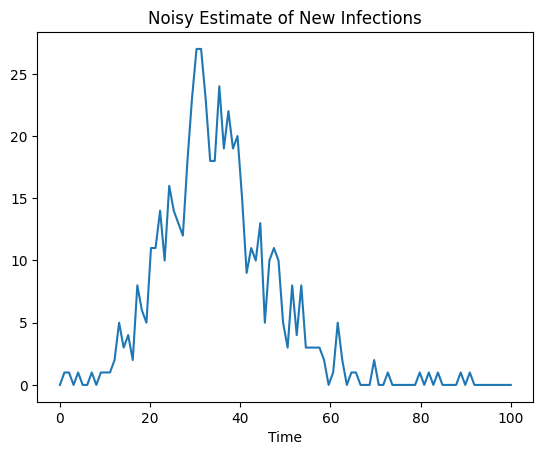

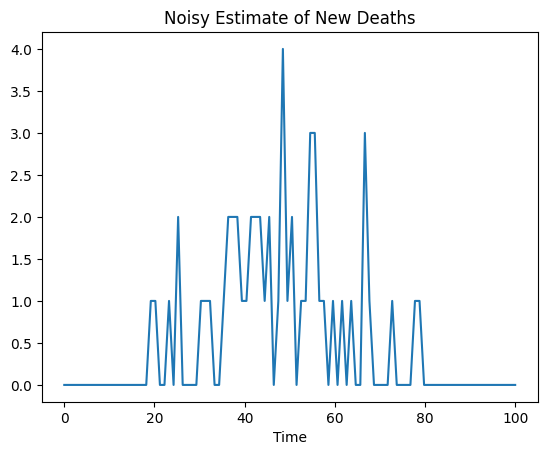

In [66]:
plt.title('Noisy Estimate of New Infections')
plt.plot(t_vec,data_newI)
plt.xlabel('Time')
plt.show()

plt.title('Noisy Estimate of New Deaths')
plt.xlabel('Time')
plt.plot(t_vec,data_newD)
plt.show()

In [67]:
@jax.jit
def log_likelihood(par):
  beta,eta,gamma,q,mu = par
  model_output = model(t_vec,jnp.array([1000.,1.,1.,0.]),(beta,eta,gamma,q,mu))
  return jnp.sum(poisson.logpmf(data_newI, jnp.exp(eta) * model_output[:,1]) + poisson.logpmf(data_newD,jnp.exp(mu) * model_output[:,2]))

In [68]:

def hmc(n_samples, x_init, n_steps, step_size,key):
    """Run Hamiltonian Monte Carlo to draw `n_samples` from the log density
    `logp`, starting at initial state `x0`.
    """
    r_scale = 1.
    # Kinetic and potential energy functions.
    T = lambda r: -norm.logpdf(r,scale = r_scale).sum()

    V = lambda x: -log_likelihood(x)

    grad_V = jax.jit(jax.grad(V))

    acc_record = jnp.zeros((n_samples,))

    dim = len(x_init)
    samples = jnp.zeros((n_samples, dim))
    samples = samples.at[0,:].set(x_init)

    for iter in range(1, n_samples):

        if(iter % 1 == 0):
             #print the acceptance rate and likelihood every 10 iterations
          print(f"iteration: {iter} | Acceptance rate: {jnp.sum(acc_record[:iter])/iter} | param vec: {jnp.exp(samples[iter-1,:])}",end = '\r')

        x_curr = samples[iter-1,:]
        key, key_r = jax.random.split(key)
        r_curr = r_scale * jax.random.normal(key = key_r, shape=(dim,))

        x_prop, r_prop = x_curr, r_curr
        for _ in range(n_steps):
            r_prop = r_prop - (step_size / 2) * grad_V(x_prop)
            x_prop = x_prop + step_size * r_prop
            r_prop = r_prop - (step_size / 2) * grad_V(x_prop)


        H_prop = T(r_prop) + V(x_prop)
        H_curr = T(r_curr) + V(x_curr)
        alpha  = jnp.exp(-H_prop + H_curr)

        key, accept_key = jax.random.split(key)
        if jax.random.uniform(minval = 0, maxval = 1, key = accept_key) < alpha:
            x_curr = x_prop
            acc_record = acc_record.at[iter].set(1)

        samples = samples.at[iter,:].set(x_curr)

    return samples



In [69]:
key = jax.random.PRNGKey(0)
key, init_key = jax.random.split(key)
key, hmc_key = jax.random.split(key)

from time import perf_counter

time_0 = perf_counter()

samples = hmc(
    n_samples=1000,
    x_init=jnp.log(jnp.array([0.1,0.1,0.1,0.1,0.05])),#beta,eta,gamma,q,mu
    n_steps=10,
    step_size=0.005,
    key = hmc_key
)

time_1 = perf_counter()

print(f"Time elapsed {time_1 - time_0}")

Time elapsed 1808.9850907619984e: 0.977977991104126 | param vec: [0.44661325 0.18757373 0.06921125 0.01327767 0.00847205]]


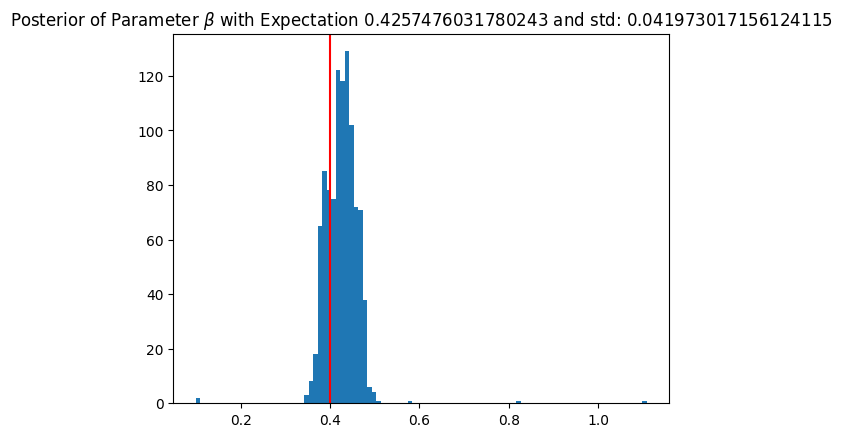

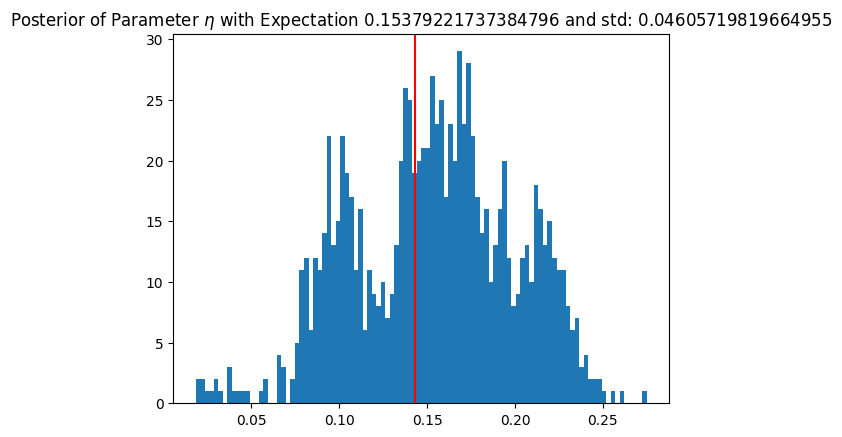

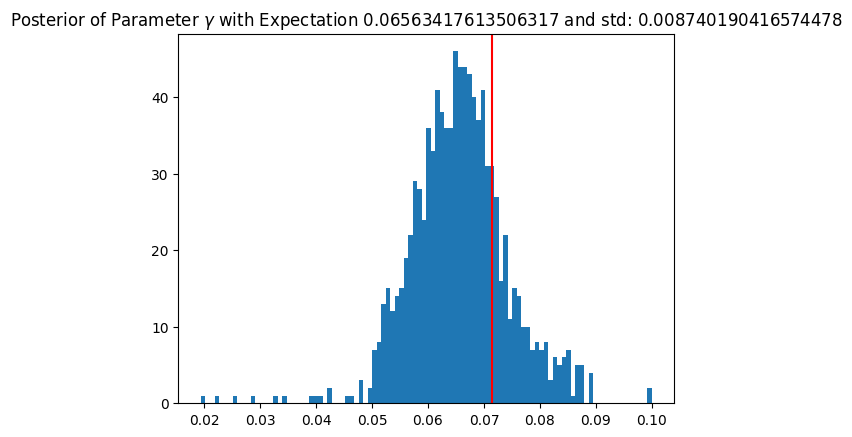

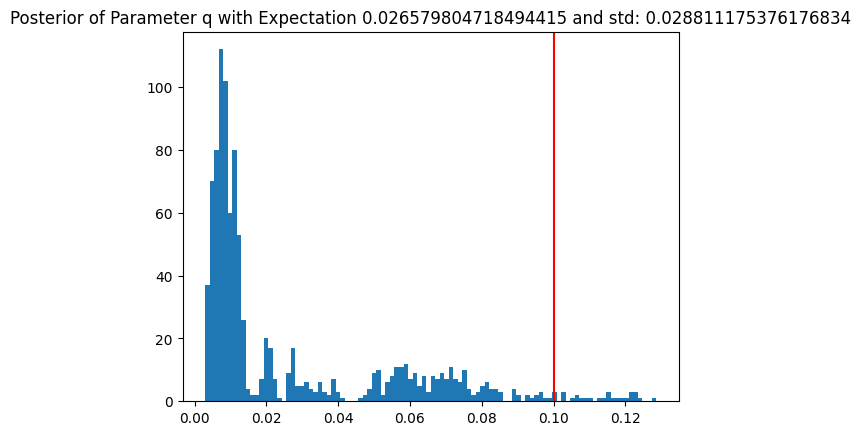

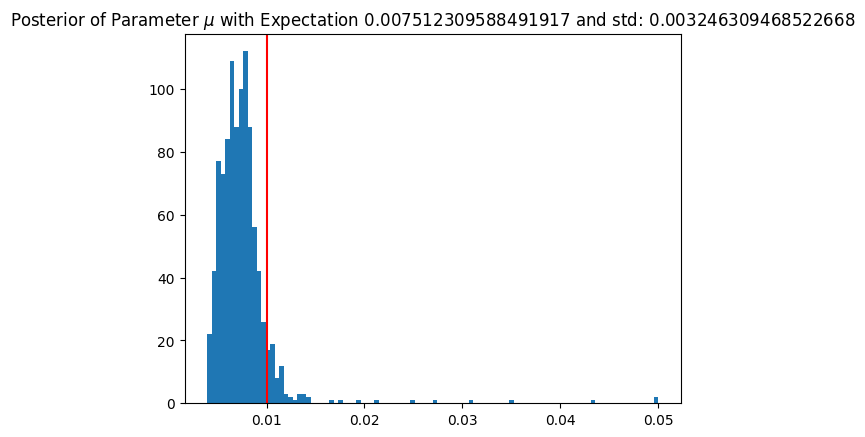

In [73]:
burn_in = 0

samples = jnp.exp(samples)

plt.title(f"Posterior of Parameter $\\beta$ with Expectation {jnp.mean(samples[:,0])} and std: {jnp.std(samples[:,0])}")
plt.hist(samples[burn_in:,0],bins = 100)
plt.axvline(jnp.exp(beta),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter $\\eta$ with Expectation {jnp.mean(samples[:,1])} and std: {jnp.std(samples[:,1])}")
plt.hist(samples[burn_in:,1],bins = 100)
plt.axvline(jnp.exp(eta),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter $\\gamma$ with Expectation {jnp.mean(samples[:,2])} and std: {jnp.std(samples[:,2])}")
plt.hist(samples[burn_in:,2],bins = 100)
plt.axvline(jnp.exp(gamma),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter q with Expectation {jnp.mean(samples[:,3])} and std: {jnp.std(samples[:,3])}")
plt.hist(samples[burn_in:,3],bins = 100)
plt.axvline(jnp.exp(q),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter $\\mu$ with Expectation {jnp.mean(samples[:,4])} and std: {jnp.std(samples[:,4])}")
plt.hist(samples[burn_in:,4],bins = 100)
plt.axvline(jnp.exp(mu),color = 'red')
plt.show()


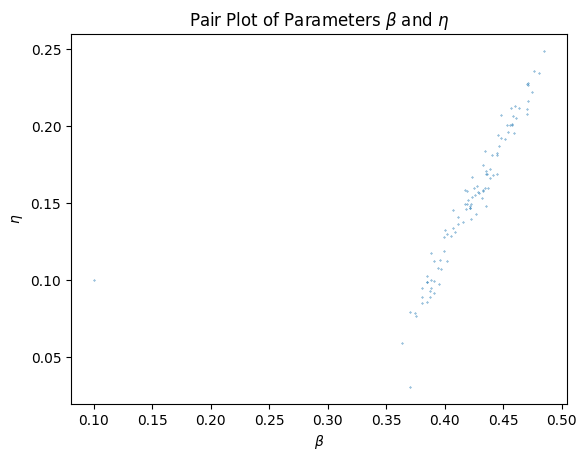

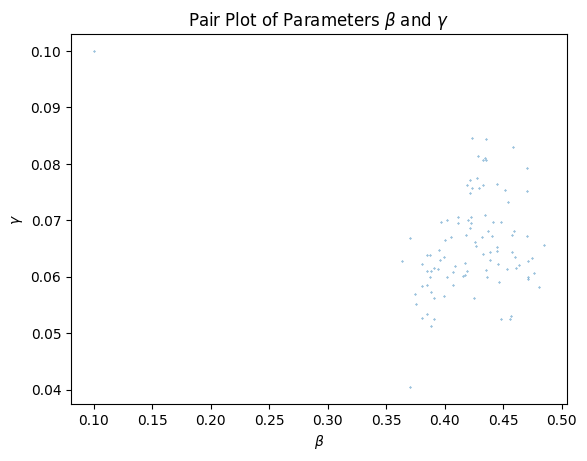

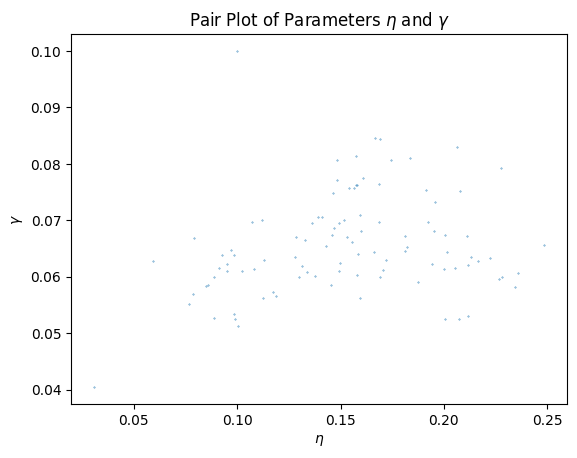

In [74]:
plt.title("Pair Plot of Parameters $\\beta$ and $\\eta$")
plt.xlabel('$\\beta$')
plt.ylabel('$\\eta$')
plt.scatter(samples[burn_in::10,0],samples[burn_in::10,1],s=0.1)
plt.show()

plt.title("Pair Plot of Parameters $\\beta$ and $\\gamma$")
plt.xlabel('$\\beta$')
plt.ylabel('$\\gamma$')
plt.scatter(samples[burn_in::10,0],samples[burn_in::10,2],s=0.1)
plt.show()

plt.title("Pair Plot of Parameters $\\eta$ and $\\gamma$")
plt.xlabel('$\\eta$')
plt.ylabel('$\\gamma$')
plt.scatter(samples[burn_in::10,1],samples[burn_in::10,2],s=0.1)
plt.show()